In [1]:
!nrnivmodl /home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod
from neuron import h
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import matplotlib.colors as mcolors
from neuron.units import ms, mV
import plotly.io as pio
from matplotlib import pyplot, cm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
from neuron import clear_gui_callback
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from numpy.linalg import pinv, eig
import numpy as np
from multiprocessing import Pool
font2={'family':'Times New Roman',
'weight':'bold',
'size': 10}
# 自定义刻度标签显示格式


h.load_file('nrngui.hoc')
h.load_file("import3d.hoc")

morphologyFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/morphologies/cell1.asc"
biophysicalModelFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCbiophys1.hoc"
biophysicalModelTemplateFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCtemplate.hoc"

h.load_file(biophysicalModelFilename)
h.load_file(biophysicalModelTemplateFilename)

/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron
Mod files: "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/CaDynamics_E2.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_HVA.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_LVAst.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/epsp.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ih.

--No graphics will be displayed.


1.0

In [2]:
import sys
sys.path.append('/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/common_function.py')
from common_function import exp_fitting, plot_curve

In [50]:
def synaptic_current(run_dt, fE, v_clamp=-65., passive=True, E = True, loc=58,
                          block='',name= '', location ='dend'):
    
    L5PC = h.L5PCtemplate(morphologyFilename)
    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = 0.
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.   
    
    if block:
        for sec in h.allsec():
            if h.ismembrane(block, sec=sec):
                # 将电导设置为0
                setattr(sec, name, 0.)
        
    h.dt = run_dt
    h.tstop = 200.
    h.v_init = -77.
    recv = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
    # Initialize an excitatory or inhibitory synaptic input
    # make a new stimulator
    stim = h.NetStim()
    

    # attach it to a synapse
    if location == 'dend':
        syn = h.Exp2Syn(L5PC.dend[int(loc)](0.9))
    if location == 'apic':
        syn = h.Exp2Syn(L5PC.apic[int(loc)](0.9))
    syn.tau1 = 1.  # ms
    syn.tau2 = 5.  # ms
    if E:
        syn.e = 0.  # mV for E input and -100 for I input
    else: 
        syn.e = -100.
    # print(syn.e)
        
    stim.number = 1
    stim.start = 100.  # ms
    ncstim = h.NetCon(stim, syn)
    ncstim.delay = 0.
    ncstim.weight[0] = 0e-2  # uS


    # Initialize voltage clamp
    vclamp = h.SEClamp(L5PC.soma[0](0.5))
    vclamp.amp1 = v_clamp
    vclamp.dur1 = h.tstop
    vclamp.dur2 = h.tstop
    vclamp.amp2 = v_clamp - 20.

    irec = h.Vector()
    irec.record(vclamp._ref_i)

    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()

    # Main simulation loop
    def main():
        
        T = 200./run_dt+1
        data = np.zeros((2, int(T)))
        ncstim.weight[0] = 0e-2
        go()
        data[0,:] = irec.to_python()  # Assuming irec is a NEURON Vector

        ncstim.weight[0] = fE
        go()
        data[1,:] = irec.to_python()  # Assuming irec is a NEURON Vector
        
        I_syn = data[1,:]-data[0,:]
        
        
        
        return I_syn
    
    
    I_syn = main()
    return I_syn[1001:]

In [90]:
def synaptic_current_parallel(args):
    v_clamp0, = args
    I_syn = synaptic_current(0.1, 1e-3, v_clamp=v_clamp0, passive = True, 
                             E = True, loc=37, block='',name= '', location ='apic')
    return I_syn
v_clamp = np.arange(-100.,0.,20.)

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 10
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(v_clamp0,) for v_clamp0 in v_clamp]

    # Apply the function in parallel
    results = pool.map(synaptic_current_parallel, args_list)

# Process the results
I_syn_tol_E = np.zeros((len(v_clamp),1000))
for i, result in enumerate(results):
    I_syn_tol_E[i,:] = result

# ground truth

In [54]:
def ground_truth(run_dt, fE, passive=True, E = True, loc=58,
                          block='',name= '', location ='dend'):
    
    L5PC = h.L5PCtemplate(morphologyFilename)
    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = 0.
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.   
    
    if block:
        for sec in h.allsec():
            if h.ismembrane(block, sec=sec):
                # 将电导设置为0
                setattr(sec, name, 0.)
        
    h.dt = run_dt
    h.tstop = 1000.
    h.v_init = -77.
    recv = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
    # Initialize an excitatory or inhibitory synaptic input
    # make a new stimulator
    stim = h.NetStim()
    

    # attach it to a synapse
    if location == 'dend':
        syn = h.Exp2Syn(L5PC.dend[int(loc)](0.9))
    if location == 'apic':
        syn = h.Exp2Syn(L5PC.apic[int(loc)](0.9))
    syn.tau1 = 1.  # ms
    syn.tau2 = 5.  # ms
    if E:
        syn.e = 0.  # mV for E input and -100 for I input
    else: 
        syn.e = -100.
    # print(syn.e)
        
    stim.number = 1
    stim.start = h.tstop-100. # ms
    ncstim = h.NetCon(stim, syn)
    ncstim.delay = 0.
    ncstim.weight[0] = 0e-2  # uS


    # Initialize voltage clamp
    vclamp = h.SEClamp(L5PC.soma[0](0.5))
    vclamp.amp1 = -77.
    vclamp.dur1 = h.tstop
    vclamp.dur2 = h.tstop
    vclamp.amp2 = -77. - 20.

    irec = h.Vector()
    irec.record(vclamp._ref_i)

    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()

    # Main simulation loop
    def main():
        
        # ground truth:
        vclamp.dur1 = 1.
        vclamp.dur2 = 1.
        vclamp.dur3 = 1.
        ncstim.weight[0] = 0e-2  # uS
        go()
        recv0 = recv.to_python()
        I0 = np.array(irec.to_python())
        V_rest = recv0[-1]
        print(V_rest)
        
         
        vclamp.amp1 = V_rest
        vclamp.dur1 = h.tstop
        vclamp.amp2 = V_rest
        vclamp.dur2 = h.tstop
        ncstim.weight[0] = fE
        go()
        I1 = np.array(irec.to_python())
        I_syn_ground = I1 - I0
        epsilonE = syn.e - V_rest
        GE_eff = I_syn_ground[9001:]/epsilonE
        
        
        return  GE_eff 
    
    
    GE_eff  = main()
    return GE_eff 

In [33]:
GE_eff = ground_truth(0.1, 1e-3,  passive = True, 
                             E = True, loc=37, block='',name= '', location ='apic')

-89.99999999866297


In [166]:
from matplotlib.ticker import FuncFormatter
def format_func(value, tick_number):
    return f'{value:.0f}'  # 将刻度值格式化为小数点后两位

def plot_curve(ax2,x,y,color='black',title='',linewidth=2, linestyle='-',xlim=[0,100],
               dx=20, ylim=[0,10],dy=5.0, fontsize=10, alpha = 1.0, xlabel='Time/ms', 
               ylabel = 'Frequency/Hz', label='',ynum_decimals =1, facecolors='none',
               nonscatter=True, s0=10, facecolor='none'):
    if nonscatter:
        if color:
            ax2.plot(x,y,color=color,linewidth=linewidth,linestyle=linestyle,alpha=alpha, label=label)
        else:
            ax2.plot(x,y,linewidth=linewidth,alpha=alpha, linestyle=linestyle,label=label)
    else:
        if color:
            ax2.scatter(x,y,edgecolors=color,facecolors = facecolor, alpha=alpha, 
                        label=label, s=s0)
        else:
            ax2.scatter(x,y, alpha=alpha, label=label,
                        s=s0)
        
    ax2.set_xlabel(xlabel,font2)
    ax2.set_ylabel(ylabel,font2)
    
    # def format_funcx(value, tick_number, num_decimals=xnum_decimals):
    #     if num_decimals==0:
    #         return f'{value:.0f}'
    #     return f'{value:.{num_decimals}f}'

    def format_funcy(value, tick_number, num_decimals=ynum_decimals):
        if num_decimals==0:
          return f'{value:.0f}'
        return f'{value:.{num_decimals}f}'

    # if dx:
    #     ax2.set_xticks(np.arange(xlim[0], xlim[1] + dx, dx))
    #     ax2.set_xticklabels(ax2.get_xticks(), fontsize=fontsize, weight='bold')
    #     ax2.set_xlim([xlim[0], xlim[1]])
        # ax2.xaxis.set_major_formatter(FuncFormatter(format_funcx))

    if dy:
        ax2.set_yticks(np.arange(ylim[0], ylim[1] + dy, dy))
        ax2.set_yticklabels(ax2.get_yticks(), fontsize=fontsize, weight='bold')
        ax2.set_ylim([ylim[0], ylim[1]])
        ax2.yaxis.set_major_formatter(FuncFormatter(format_funcy))
        
  
    if xlim:
       ax2.set_xticks(np.arange(xlim[0],xlim[1]+dx,dx))
       ax2.set_xticklabels(np.arange(xlim[0],xlim[1]+dx,dx),fontsize=fontsize,weight='bold')
       ax2.set_xlim(xlim)
    # if ylim:
    #    ax2.set_yticks(np.arange(ylim[0],ylim[1]+dy,dy))
    #    ax2.set_yticklabels(np.arange(ylim[0],ylim[1]+dy,dy),fontsize=10,weight='bold')
    #    ax2.set_ylim(ylim)
    if title:
       ax2.set_title('{0}'.format(title),fontsize=fontsize,weight='bold')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    if label:
       ax2.legend(loc='best',prop=font2,edgecolor='white')


/home/wzl/anaconda/envs/nest/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


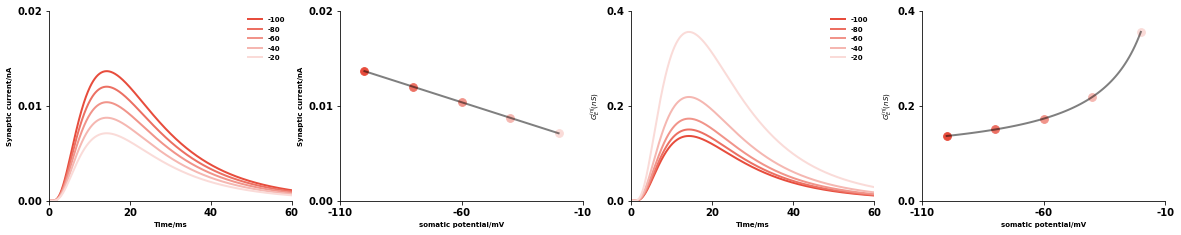

In [132]:
from scipy.optimize import curve_fit

# 定义模型函数
def model(x, a, b, c):
    return a + b / (x + c)
time=np.linspace(0,100,np.shape(I_syn_tol_E)[1])
# color= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
# color= ['#6a9373', '#b5b788', '#e0d4ba', '#f9ebc7', '#f2d3ae']
color = ['#E74C3C', '#EC7063', '#F1948A', '#F5B7B1', '#FADBD8']

v_clamp = np.arange(-100.,0.,20.)
est_cond_time_E = (-I_syn_tol_E/(0. - v_clamp[:,np.newaxis]))*1e3
est_cond_peak_E = np.max(est_cond_time_E, axis=1)
I_syn_peak_E = np.max(-I_syn_tol_E, axis=1)
A = np.ones((len(v_clamp),2))
A[:,0] = v_clamp
x, residuals, rank, singular_values = np.linalg.lstsq(A, I_syn_peak_E, rcond=None)

s0=60
fig, ax2 = plt.subplots(1,4, figsize = (20,3.5))
for i in range(np.shape(I_syn_tol_E)[0]):
    plot_curve(ax2[0],time,-I_syn_tol_E[i,:],color=color[i],label=int(v_clamp[i]),xlim=[0,60], dx=20,
               ylim=[0.,0.02], dy=0.01,ynum_decimals=2, ylabel='Synaptic current/nA')
    plot_curve(ax2[1],v_clamp[i],I_syn_peak_E[i],color=color[i], xlim=[-110,10], dx=25,
                ylim=[0.,0.02], dy=0.01,ynum_decimals=2, xlabel='somatic potential/mV',
                ylabel='Synaptic current/nA', facecolor=color[i],nonscatter=False, s0=s0)
    plot_curve(ax2[2],time,est_cond_time_E[i,:],color=color[i],label=int(v_clamp[i]),xlim=[0,60], dx=20,
               ylim=[0.,0.4], dy=0.2,ynum_decimals=1, ylabel=r'$G^{inj}_E(nS)$')
    plot_curve(ax2[3],v_clamp[i],est_cond_peak_E[i],color=color[i], xlim=[-110,10], dx=25,
                ylim=[0.,0.4], dy=0.2,ynum_decimals=1,
                ylabel=r'$G^{inj}_E(nS)$', xlabel='somatic potential/mV',
                nonscatter=False, facecolor=color[i], s0=s0)
    
plot_curve(ax2[1],v_clamp,x[1]+x[0]*v_clamp,color='black', xlim=[-110,-10], dx=50,
                ylim=[0.,0.02], dy=0.01,ynum_decimals=2, ylabel='Synaptic current/nA',
                nonscatter=True,  xlabel='somatic potential/mV',alpha=0.5)

# # 使用 interp1d 进行插值
# f = interp1d(v_clamp, est_cond_peak_E, kind='cubic')

# # 生成光滑的曲线上的更多点
# x_smooth = np.linspace(-100., -20.,100)
# y_smooth = f(x_smooth)

# plot_curve(ax2[3],x_smooth,y_smooth,color='black', xlim=[-110,-10], dx=50,
#                 ylim=[0.,0.4], dy=0.2,ynum_decimals=1, ylabel=r'$G^{inj}_E(nS)$', xlabel='somatic potential/mV',
#                 nonscatter=True, alpha=0.5)
params, params_covariance = curve_fit(model, v_clamp, est_cond_peak_E, p0=[1, 1, 1])
x = np.linspace(v_clamp[0],v_clamp[-1],100)
y = model(x, params[0], params[1], params[2])
plot_curve(ax2[3],x, y, color='black', xlim=[-110,-10], dx=50,
                ylim=[0.,0.4], dy=0.2,ynum_decimals=1, ylabel=r'$G^{inj}_E(nS)$', xlabel='somatic potential/mV',
                nonscatter=True, alpha=0.5)

plt.savefig('interaction_betweenIinj_IsynE.eps', format='eps')

0.14243568029418932
[0.04320204 0.05278471 0.21276262 0.53271846 1.49258595]


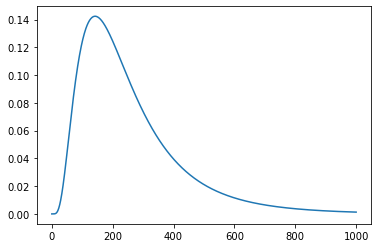

In [42]:
plt.plot(-GE_eff*1e3)
true_GE_peak = np.max(-GE_eff*1e3)
error = np.abs(est_cond_peak_E - true_GE_peak)/true_GE_peak
print(true_GE_peak)
print(error)

In [135]:
def synaptic_current_parallel(args):
    v_clamp0, = args
    I_syn = synaptic_current(0.1, 1e-3, v_clamp=v_clamp0, passive = True, 
                             E = False, loc = 41, block='',name= '', location ='apic')
    return I_syn
v_clamp = np.array([-160., -150., -130., -120., -110., -107.])
# v_clamp = np.arange(-100.,-0.,20.)

# Create a Pool with desired number of processes (adjust as needed)
num_processes = 10
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(v_clamp0,) for v_clamp0 in v_clamp]

    # Apply the function in parallel
    results = pool.map(synaptic_current_parallel, args_list)

# Process the results
I_syn_tol_I = np.zeros((len(v_clamp),1000))
for i, result in enumerate(results):
    I_syn_tol_I[i,:] = result

In [89]:
GI_eff = ground_truth(0.1, 1e-3, passive = True, 
                            E = False, loc = 41, block='',name= '', location ='apic')

-89.99999999866297


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


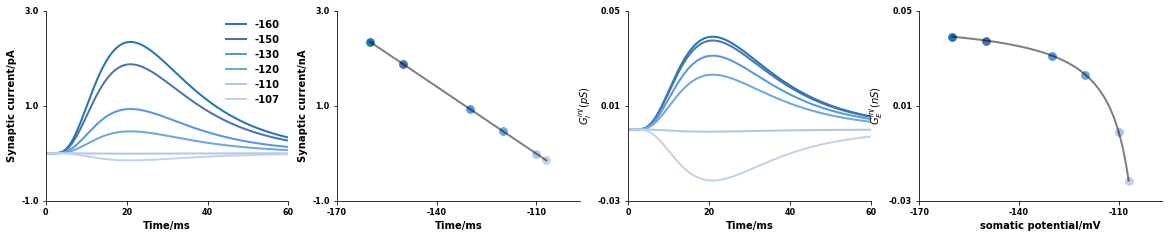

In [175]:
time=np.linspace(0,100,np.shape(I_syn_tol_I)[1])
# color= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
# color= ['#6a9373', '#b5b788', '#e0d4ba', '#f9ebc7', '#f2d3ae']
color = ['#1f77b4', '#4c72b0', '#5596e6', '#6da7de', '#aec7e8', '#c2d3e9']
vmin = int(v_clamp[0]-10)
vmax = int(v_clamp[-1]+10)
est_cond_time_I = (-I_syn_tol_I/(-100. - v_clamp[:,np.newaxis]))*1e3
index_cond = np.argmax(np.abs(est_cond_time_I), axis=1)
index_I= np.argmax(np.abs(I_syn_tol_I), axis=1)
est_cond_peak_I = np.zeros(len(v_clamp))
I_syn_peak_I = np.zeros(len(v_clamp))
for i in range(len(est_cond_peak_I)):
    est_cond_peak_I[i] = est_cond_time_I[i,index_cond[i]]
    I_syn_peak_I[i] = -I_syn_tol_I[i, index_I[i]]
    
A = np.ones((len(v_clamp),2))
A[:,0] = v_clamp
x, residuals, rank, singular_values = np.linalg.lstsq(A, I_syn_peak_I*1e3, rcond=None)
s0 = 60
fontsize0 =8

fig, ax2 = plt.subplots(1,4, figsize = (20,3.5))
for i in range(np.shape(I_syn_tol_I)[0]):
    plot_curve(ax2[0],time,-I_syn_tol_I[i,:]*1e3,color=color[i],label=int(v_clamp[i]),
               xlim=[0,60], dx=20, fontsize=fontsize0,
               ylim=[-1,3], dy=2,ynum_decimals=1, ylabel='Synaptic current/pA')
    plot_curve(ax2[1],v_clamp[i],I_syn_peak_I[i]*1e3,color=color[i],
                xlim=[vmin,vmax], dx=30, fontsize=fontsize0,
                ylim=[-1,3], dy=2,ynum_decimals=1, xlabel='somatic potential/mV',
                ylabel='Synaptic current/pA', nonscatter=False, s0=s0,  facecolor=color[i])
    
    plot_curve(ax2[2],time,est_cond_time_I[i,:],color=color[i],xlim=[0,60], dx=20,fontsize=fontsize0,
               ylim=[-0.03,0.05], dy=0.04,ynum_decimals=2, ylabel=r'$G^{inj}_I(pS)$')
    
    plot_curve(ax2[3],v_clamp[i],est_cond_peak_I[i],color=color[i],
                xlim=[vmin,vmax], dx=30, fontsize=fontsize0,
                ylim=[-0.03,0.05], dy=0.04,ynum_decimals=1, ylabel=r'$G^{inj}_I(pS)$',
                xlabel='somatic potential/mV',
                nonscatter=False, s0=s0,  facecolor=color[i])
    
plot_curve(ax2[1],v_clamp,x[1]+x[0]*v_clamp,color='black', xlim=[vmin,vmax], dx=30,
                ylim=[-1,3], dy=2,ynum_decimals=1, ylabel='Synaptic current/nA',
                nonscatter=True,fontsize=fontsize0, alpha=0.5)


params, params_covariance = curve_fit(model, v_clamp, est_cond_peak_I, p0=[0.04, -0.2, 100.], maxfev = 2000)
x = np.linspace(v_clamp[0],v_clamp[-1],100)
y = model(x, params[0], params[1], params[2])
plot_curve(ax2[3],x, y, color='black', xlim=[vmin,vmax], dx=30,fontsize=fontsize0,
                ylim=[-0.03,0.05], dy=0.04, ynum_decimals=2, ylabel=r'$G^{inj}_E(nS)$', xlabel='somatic potential/mV',
                nonscatter=True, alpha=0.5)

plt.savefig('interaction_betweenIinj_IsynI.eps', format='eps')

0.1478499507656601
[0.04320204 0.05278471 0.21276262 0.53271846 1.49258595]


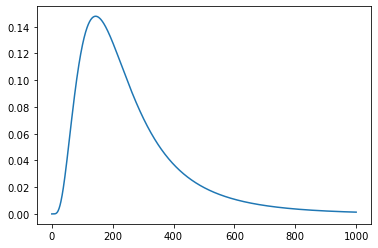

In [177]:
plt.plot(-GI_eff*1e3)
true_GI_peak = np.max(-GI_eff*1e3)
errorI = np.abs(est_cond_peak_I - true_GI_peak)/true_GI_peak
print(true_GI_peak)
print(error)